## Preprocessing Dyamond

Converting the data into npy makes it possible for us to work with it efficiently; originally we require 500GB of RAM which is always difficult to guarantee. We preprocess dyamond in another ipynb notebook precisely because of this issue.

1) We read the data
2) Reshape variables so that they have equal dimensionality
3) Reshape into data samples fit for the NN and convert into a DataFrame
4) Downsample the data: Remove data above 21kms, remove condensate-free clouds, combat class-imbalance
5) Split into input and output
6) Save as npy

Note: We neither scale nor split the data into training/validation/test sets. <br>
The reason is that i) in order to scale we need the entire dataset but this can only be done in conjunction with the dyamond dataset. Also for cross-validation different scalings will be necessary based on different subsets of the data, ii) The split into subsets will be done by the cross-validation procedure or not at all when training the final model.

In [1]:
# Ran with 450GB

import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import gc
# import importlib
# importlib.reload(my_classes)

base_path = '/home/b/b309170'
output_path = base_path + '/my_work/icon-ml_data/cloud_cover_parameterization/neighborhood_based_DYAMOND/'

# Add path with my_classes to sys.path
sys.path.insert(0, base_path + '/workspace_icon-ml/cloud_cover_parameterization/')

from my_classes import load_data

# ['all', 'discard_spinup']
days = 'discard_spinup'

VERT_LAYERS = 31

#Set a numpy seed for the permutation later on!
np.random.seed(10)

## 1) Reading the data
### Input:
- fr_land: Fraction of land
- coriolis: Coriolis parameter
- zg: Geometric height at full levels (3D)
- qv: Specific water vapor content (3D)
- qc: Specific cloud water content (3D)
- qi: Specific cloud ice content (3D)
- temp: Temperature (3D)
- pres: Pressure (3D)
- u: Zonal wind (3D)
- v: Meridional wind (3D)

$10$ input nodes

### Output:
- clc: Cloud Cover

$1$ output nodes

The data above 21km is capped.

In [2]:
# For cl_area I only need the output as I already have the input
# I still need 'clw', 'cli' for condensate-free clouds
order_of_vars_dyamond = ['hus', 'clw', 'cli', 'ta', 'pa', 'ua', 'va', 'zg', 'coriolis', 'clc', 'cl_area']

In [3]:
# Load dyamond data
data_dict = load_data(source='split_by_var_name', days=days, resolution='R02B05', order_of_vars=order_of_vars_dyamond, 
                      path='/home/b/b309170/bd1179_work/DYAMOND/hvcg_data')

hus
clw
cli
ta
pa
ua
va
clc
cl_area


In [4]:
# Convert the data to float32 and remove layers above 21km asap!
for key in data_dict.keys():
    data_dict[key] = np.float32(data_dict[key])
gc.collect()

1600

In [5]:
for key in data_dict.keys():
    print(key, data_dict[key].shape)

hus (467, 31, 79342)
clw (467, 31, 79342)
cli (467, 31, 79342)
ta (467, 31, 79342)
pa (467, 31, 79342)
ua (467, 31, 79342)
va (467, 31, 79342)
zg (31, 79342)
coriolis (79342,)
clc (467, 31, 79342)
cl_area (467, 31, 79342)


In [6]:
(TIME_STEPS, VERT_LAYERS, HORIZ_FIELDS) = data_dict['clc'].shape

In [7]:
#Reshaping into nd-arrays of equaling shapes (don't reshape in the vertical)
data_dict['zg'] = np.repeat(np.expand_dims(data_dict['zg'], 0), TIME_STEPS, axis=0)
try: 
    data_dict['coriolis'] = np.repeat(np.expand_dims(data_dict['coriolis'], 0), TIME_STEPS, axis=0)
    data_dict['coriolis'] = np.repeat(np.expand_dims(data_dict['coriolis'], 1), VERT_LAYERS, axis=1)
    # Surface temperature (Try without?)
    temp_sfc = np.repeat(np.expand_dims(data_dict['ta'][:, -1, :], axis=1), VERT_LAYERS, axis=1)
except: 
    print('There is probably no coriolis or temperature in order_of_vars_dyamond')
    pass

In [8]:
# Remove the first timesteps of the dyamond simulations since the clc values are 0 across the entire earth there 
remove_steps = []
for i in range(data_dict['clc'].shape[0]):
    if np.all(data_dict['clc'][i,4:,:] == 0):
        remove_steps.append(i)
        TIME_STEPS = TIME_STEPS - 1

for key in data_dict.keys():
    data_dict[key] = np.delete(data_dict[key], remove_steps, axis=0)
        
try:
    temp_sfc = np.float32(np.delete(temp_sfc, remove_steps, axis=0))
except:
    print('There is probably no temperature in order_of_vars_dyamond')
    pass

In [9]:
# Our Neural Network has trained with clc in [0, 100]!
data_dict['clc'] = 100*data_dict['clc']
data_dict['cl_area'] = 100*data_dict['cl_area']
print(np.max(data_dict['clc'][:, 4:, :]))
print(np.max(data_dict['cl_area'][:, 4:, :]))

100.000015
100.0


In [10]:
# Carry along information about the vertical layer of a grid cell. int16 is sufficient for < 1000.
vert_layers = np.int16(np.repeat(np.expand_dims(np.arange(1, VERT_LAYERS+1), 0), TIME_STEPS, axis=0))
vert_layers = np.repeat(np.expand_dims(vert_layers, 2), HORIZ_FIELDS, axis=2)
vert_layers.shape

(467, 31, 79342)

In [11]:
# Add variables below and above

def add_above_and_below(var_array):
    '''
        var_array: 3D tensor
    '''
    above = (np.insert(var_array, obj=0, values=1000*np.ones((TIME_STEPS, HORIZ_FIELDS)), axis=1))[:, :-1, :]
    # Replace by the entry from the same cell if the one above is nan.
    # It is a bit suboptimal that the ones above can be nan. 
    # But in dyamond this only pertains the cli, clw and hus which are zero anyways at 21kms.
    nan_indices = np.where(np.isnan(above))
    above[nan_indices] = above[nan_indices[0], nan_indices[1]+1, nan_indices[2]]
    
    # Below is the same value as the grid cell for surface-closest layer
    below = (np.append(var_array, values=var_array[:, -1:, :], axis=1))[:, 1:, :]
    return above, below

above = {}
below = {}

# 1000 is a value that cannot be attained physically and serves as our way of checking whether the grid cell is at the model top
# It makes sense to insert 0 as the difference at the lowest levels. (Note that the values won't stay 0 after normalization) 
# The NN could get around these values that are not really physical by weighing the influence from below with a zg-factor.
# Alternatively we would have to remove the variable from below altogether

for key in order_of_vars_dyamond[:-2]:
    above[key], below[key] = add_above_and_below(data_dict[key])

In [12]:
# Reshaping into 1D-arrays and converting dict into a DataFrame-object (the following is based on Aurelien Geron)
for key in data_dict.keys():
    data_dict[key] = np.reshape(data_dict[key][:, 4:], -1) 
vert_layers = np.reshape(vert_layers[:, 4:], -1)
    
for key in order_of_vars_dyamond[:-3]:
    data_dict['%s_below'%key] = np.reshape(below[key][:, 4:], -1)
    data_dict['%s_above'%key] = np.reshape(above[key][:, 4:], -1)
    
try:
    data_dict['temp_sfc'] = np.reshape(temp_sfc[:, 4:], -1)
except:
    print('There is probably no (surface) temperature.')
    pass

import gc
del above, below, temp_sfc
gc.collect()

# This line takes quite some memory
df = pd.DataFrame.from_dict(data_dict)
df.head()

,hus,clw,cli,ta,pa,ua,va,zg,coriolis,clc,...,ta_above,pa_below,pa_above,ua_below,ua_above,va_below,va_above,zg_below,zg_above,temp_sfc
0,0.000003,0.0,0.0,219.129974,5136.635742,0.199283,0.779119,20784.626953,0.000116,0.0,...,219.532318,6663.091797,3941.898438,1.512052,0.767833,2.054968,0.747552,19153.337891,22500.869141,287.408600
1,0.000003,0.0,0.0,219.263229,5137.106445,0.513316,1.568327,20784.626953,0.000116,0.0,...,219.466461,6661.952637,3941.960693,1.693404,1.040440,2.050681,0.517685,19153.337891,22500.869141,288.236633
2,0.000003,0.0,0.0,218.753555,5136.911621,0.472010,0.123696,20784.626953,0.000116,0.0,...,219.898621,6661.618164,3942.130371,1.445639,0.097300,1.020722,1.078983,19153.337891,22500.869141,287.695953
3,0.000003,0.0,0.0,218.543854,5135.631348,-0.288119,1.658352,20784.626953,0.000115,0.0,...,219.964767,6666.223145,3940.980713,1.786568,0.386054,1.192030,0.172811,19153.337891,22500.869141,286.954590
4,0.000003,0.0,0.0,219.162125,5135.462891,0.390922,1.529522,20784.626953,0.000118,0.0,...,220.277863,6657.734863,3943.317627,1.525171,-0.314244,0.191374,0.846919,19153.337891,22500.869141,288.169342


**Afterwards I removed coriolis_below and coriolis_above which were mistakenly included in the old code! I also updated the code here, just the output is old.**

In [13]:
import gc
del data_dict
gc.collect()

0

**Downsampling the data (minority class: clc = 0)**

In [14]:
# There are no nans left
assert np.all(np.isnan(df) == False) == True

In [15]:
# Some quick sanity checks regarding the input data
assert np.all(df['ta'] > 150) and np.all(df['pa'] > 150)

#The upper levels have been cut off so there are no wrong values in the data anymore
assert df[df['ta_above']==1000].shape[0] == 0 

In [16]:
# There are no condensate-free clouds
df.loc[((df['clc'] > 0) & (df['clw'] == 0) & (df['cli'] == 0))]

,hus,clw,cli,ta,pa,ua,va,zg,coriolis,clc,...,ta_above,pa_below,pa_above,ua_below,ua_above,va_below,va_above,zg_below,zg_above,temp_sfc


In [17]:
# Unfortunately this does not hold for cl_area which is not diagnosed perfectly due to the intermediate grid
print(len(df.loc[((df['cl_area'] > 0) & (df['clw'] == 0) & (df['cli'] == 0))])/len(df))
print(len(df.loc[((df['cl_area'] > 1) & (df['clw'] == 0) & (df['cli'] == 0))])/len(df))
print(len(df.loc[((df['cl_area'] > 10) & (df['clw'] == 0) & (df['cli'] == 0))])/len(df))
print(len(df.loc[((df['cl_area'] > 50) & (df['clw'] == 0) & (df['cli'] == 0))])/len(df))

0.0016189927160011565
0.0003966261168904948
4.604451037173887e-05
1.7092765008612685e-07


In [18]:
if days == 'all':
    # We ensure that clc != 0 is as large as clc = 0 (which then has 294 Mio samples) and keep the original order intact
    df_noclc = df.loc[df['clc']==0]
    print(len(df_noclc))

    # len(downsample_indices) will be the number of noclc samples that remain
    downsample_ratio = (len(df) - len(df_noclc))/len(df_noclc)
    shuffled_indices = np.random.permutation(df_noclc.index)
    size_noclc = int(len(df_noclc)*downsample_ratio)

    del df_noclc
    gc.collect()

    downsample_indices = shuffled_indices[:size_noclc] 

    # Concatenate df.loc[df[output_var]!=0].index and downsample_indices
    final_indices = np.concatenate((downsample_indices, df.loc[df['clc']!=0].index))

    del shuffled_indices, downsample_indices
    gc.collect()

    # Sort final_indices so that we can more or less recover the timesteps
    final_indices = np.sort(final_indices)
elif days == 'discard_spinup':
    final_indices = np.load('/home/b/b309170/my_work/icon-ml_data/cloud_cover_parameterization/neighborhood_based_SR_DYAMOND/indices_to_keep_after_downsampling.npy')

# Label-based (loc) not positional-based
df = df.loc[final_indices]

In [19]:
# Number of samples after downsampling
len(df)

285179494

In [20]:
#Modifies df as well
def split_input_output(dataset):
    output_clc = dataset['clc']
    output_cl_area = dataset['cl_area']
    del dataset['clc']
    del dataset['cl_area']
    return output_clc, output_cl_area

In [21]:
output_clc, output_cl_area = split_input_output(df)

In [22]:
# Save the data
if days == 'all':
    np.save(output_path + '/cloud_cover_input_dyamond.npy', np.float32(df))
    np.save(output_path + '/cloud_cover_output_dyamond.npy', np.float32(output_clc))
    np.save(output_path + '/cloud_area_output_dyamond.npy', np.float32(output_cl_area))
    np.save(output_path + '/samples_vertical_layers_dyamond.npy', vert_layers[df.index])
elif days == 'discard_spinup':
    np.save(output_path + '/cloud_cover_input_dyamond_no_spinup.npy', df)
    np.save(output_path + '/cloud_cover_output_dyamond_no_spinup.npy', output_clc)
    np.save(output_path + '/cloud_area_output_dyamond_no_spinup.npy', output_cl_area)
    np.save(output_path + '/samples_vertical_layers_dyamond_no_spinup.npy', vert_layers[df.index])

Some tests of the cloud area output

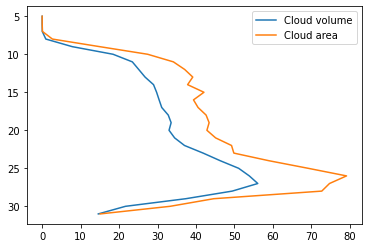

In [26]:
a = np.arange(5, 32)
means_clc = []
means_cl_area = []
for k in range(5, 32):
    means_clc.append(np.mean(output_clc[vert_layers == k]))
    means_cl_area.append(np.mean(output_cl_area[vert_layers == k]))
plt.plot(means_clc, a)
plt.plot(means_cl_area, a)
plt.legend(['Cloud volume', 'Cloud area'])
plt.gca().invert_yaxis()

In [27]:
diff = output_cl_area - output_clc

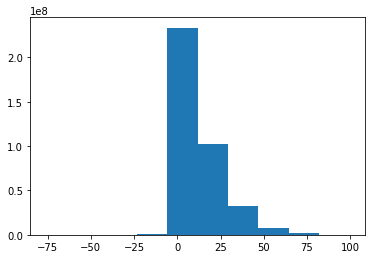

In [28]:
plt.hist(diff, bins = 10)
plt.show()

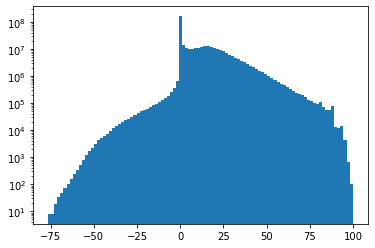

In [29]:
plt.hist(diff, bins = 100, log=True)
plt.show()

In [30]:
# These should be anomalies existing due to differences in coarse-graining
len(np.where(diff < 0)[0])

3421827

In [31]:
len(np.where(diff > 0)[0])

231274379

In [32]:
len(np.where(diff >= 0)[0])

375528913

In [33]:
len(np.where(diff < 0)[0])/len(diff) # 0.9% of the data

0.00902974091038851

In [34]:
len(np.where(diff < 0)[0])/len(np.where(diff != 0)[0]) # 1.4% of cloudy data

0.01457981387223618